In [1]:
from src import read_yfinance_crypto_data
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import yfinance as yf
yf.__cache__ = {}

/root/cryptobot-enviroment/.venv/lib/python3.12/site-packages/numpy/_core/getlimits.py:545: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)
2025-01-02 23:08:18.561558: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-02 23:08:18.573424: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-02 23:08:18.599038: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735870098.636198    2153 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plu

In [2]:
seq_len = 90
tested_model = "ata-p90-1f-2L.keras"

In [3]:
%reload_ext autoreload
%autoreload 2

#simulate training scaler
ticker = yf.Ticker("ATA-USD",)
puppet = ticker.history("max", "1d")

puppet = puppet["Close"].values.reshape(-1,1)
trainingScaler = MinMaxScaler()
normalizedTrainingData = trainingScaler.fit_transform(puppet)
normalizedTrainingData.shape

(1306, 1)

In [14]:
# connect to yfinance and get last 180 days data (data preparation eats first 90 days)
df = read_yfinance_crypto_data("ATA-USD", "1y", "1d")
pastData = df["Close"].values.reshape(-1,1)

# normalize the pastData on the training scaler
normalizedPastData = trainingScaler.transform(pastData)
normalizedPastData.shape

(366, 1)

In [10]:
# load model
model = tf.keras.models.load_model(f"./saved_models/{tested_model}")
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 90, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 363,905 (1.39 MB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 242,604 (947.68 KB)

In [27]:
initial_sum = 100
buyed = False
predictions = []
for i in range(seq_len, len(normalizedPastData)):
    print(i)
    inputs = normalizedPastData[i-seq_len:i]
    pred = model(inputs.reshape(1, seq_len, 1 ))
    predictions.append(pred[0])
    predicted_price_difference = pred[0] - pastData[i-1]

    print(f"predicted dif {predicted_price_difference} sum: {initial_sum} {predicted_price_difference[0] > 0}")
    if (buyed):
        print(f"- predicted op diff: {pastData[i-1] - buy_value}")

    if (predicted_price_difference[0] > 0):
        if (not buyed):
            buy_value = pastData[i-1]
            buy_amount = initial_sum / pastData[i-1]
            buyed = True
            print(f"buy val: { buy_value} buy amount: {buy_amount}"  )
    else:
        if (buyed):
            operation_difference =  pastData[i-1] - buy_value
            print("op. diff ", operation_difference )
            initial_sum += operation_difference * buy_amount
            buyed = False
            print("sum ", initial_sum )
            print("\n\n")

initial_sum


90
predicted dif [0.00987512] sum: 100 True
buy val: [0.173026] buy amount: [577.94783793]
91
predicted dif [0.01320863] sum: 100 True
- predicted op diff: [-0.009215]
92
predicted dif [-0.00046848] sum: 100 False
- predicted op diff: [0.00359701]
op. diff  [0.00359701]
sum  [102.07888196]



93
predicted dif [-0.0475885] sum: [102.07888196] False
94
predicted dif [0.01440835] sum: [102.07888196] True
buy val: [0.190855] buy amount: [534.85045642]
95
predicted dif [0.00976104] sum: [102.07888196] True
- predicted op diff: [0.00385]
96
predicted dif [0.00572588] sum: [102.07888196] True
- predicted op diff: [0.00653601]
97
predicted dif [-0.00880679] sum: [102.07888196] False
- predicted op diff: [0.026549]
op. diff  [0.026549]
sum  [116.27862489]



98
predicted dif [-0.00632887] sum: [116.27862489] False
99
predicted dif [0.00302693] sum: [116.27862489] True
buy val: [0.215837] buy amount: [538.73350685]
100
predicted dif [-0.02048066] sum: [116.27862489] False
- predicted op diff: [0

array([117.80622297])

(366, 1) (366,)


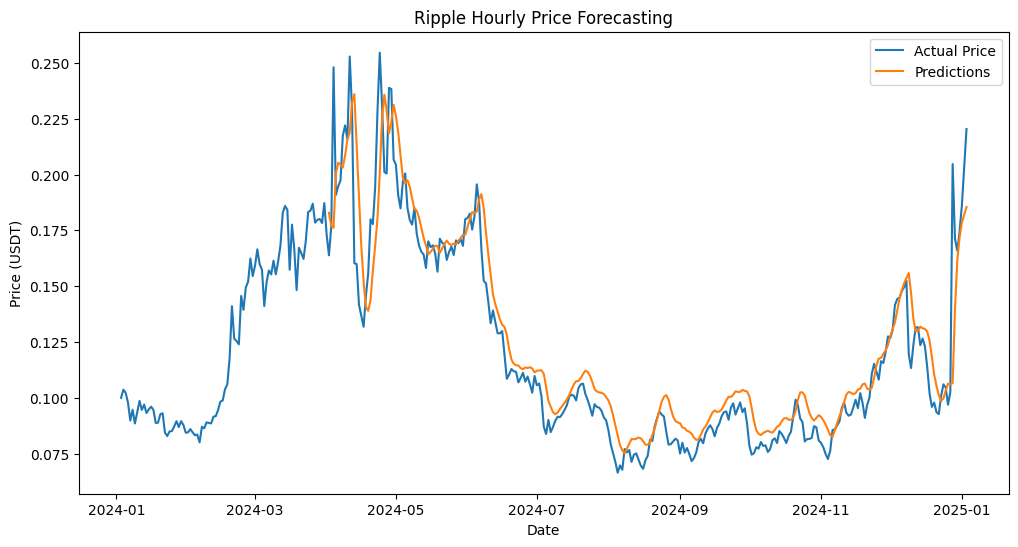

In [28]:
import matplotlib.pyplot as plt
timeseries = df.index
print(pastData.shape, timeseries.shape)
# Plot result

plt.figure(figsize=(12, 6))
plt.plot(timeseries, pastData, label='Actual Price')
plt.plot(timeseries[seq_len:], predictions[:], label='Predictions')
plt.title('Ripple Hourly Price Forecasting')
plt.xlabel('Date')
plt.ylabel('Price (USDT)')
plt.legend()
plt.show()